In [1]:
""" Imports """
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button, RadioButtons
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 
# matplotlib.rcParams.update({'font.size': 22})
%matplotlib qt

In [8]:
""" Functions """

""" Quick function to wrangle a date object into the format we need to index from our dataframe"""
def format_date(date):
    day = date.day
    month = date.month
    year = date.year-2000
    return '/'.join([str(x) for x in [month, day, year]])

## Setup

In [3]:
""" Load the data """
usa_map = gpd.read_file('misc/cb_2019_us_county_20m.shp')
world_data_7DMA = pd.read_csv('daily-covid-cases-7-day.csv')
usa_data_7DMA = world_data_7DMA.loc[world_data_7DMA['Code']=='USA']
usa_data_7DMA = usa_data_7DMA.reset_index(drop=True)
county_data = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv')
county_populations = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv')

""" Add in county population data """
county_data['population'] = county_populations.pop('population')
    
""" Couple of data wrangling steps """
county_data.dropna(inplace=True)
usa_map.dropna(inplace=True)
usa_map = usa_map.astype({'GEOID':'int64'})

In [4]:
# Establish starting date
day1 = datetime.date(month=1, day=22, year=2020)

## Format the US-wide data to be cleaner to pull from

In [5]:
start_idx = np.where(usa_data_7DMA['Date']==str(day1+timedelta(6)))[0][0]
x = usa_data_7DMA.iloc[start_idx:]['Daily new confirmed cases due to COVID-19 (rolling 7-day average, right-aligned)'].values
cols = usa_data_7DMA.iloc[start_idx:]['Date'].values
# Reformat the datestrings in cols
cols = [format_date(datetime.datetime.strptime(date, "%Y-%m-%d")) for date in cols]
usa_data_7DMA_new = pd.Series(x, index=cols)
# print(usa_data_7DMA_new)

1/28/20        0.57143
1/29/20        0.57143
1/30/20        0.57143
1/31/20        0.71429
2/1/20         0.71429
              ...     
10/3/20    42693.57143
10/4/20    43449.42857
10/5/20    43257.00000
10/6/20    44358.00000
10/7/20    44364.42857
Length: 254, dtype: float64


## Calculate 7 day moving average for new infections at the county level

In [6]:
county_data_7DMA = county_data[['countyFIPS','County Name','State','stateFIPS','population']].copy()
days_since_day1 = (datetime.date.today()-day1).days
for ii in range(days_since_day1 - 7):
    week_start = format_date(day1 + timedelta(ii))
    week_end = format_date(day1 + timedelta(ii + 6))
    avg = (county_data[week_end] - county_data[week_start])/7
    pct = avg/county_data['population'] * 100
    county_data_7DMA[week_end] = pct
# print(county_data_7DMA)

      countyFIPS            County Name State  stateFIPS  population  1/28/20  \
0              0  Statewide Unallocated    AL          1           0      NaN   
1           1001         Autauga County    AL          1       55869      0.0   
2           1003         Baldwin County    AL          1      223234      0.0   
3           1005         Barbour County    AL          1       24686      0.0   
4           1007            Bibb County    AL          1       22394      0.0   
...          ...                    ...   ...        ...         ...      ...   
3190       56037      Sweetwater County    WY         56       42343      0.0   
3191       56039           Teton County    WY         56       23464      0.0   
3192       56041           Uinta County    WY         56       20226      0.0   
3193       56043        Washakie County    WY         56        7805      0.0   
3194       56045          Weston County    WY         56        6927      0.0   

      1/29/20  1/30/20  1/3

## Merge county data with the geodataframe using outer join 

In [7]:
combined = usa_map.merge(county_data_7DMA, how='outer', left_on='GEOID', right_on='countyFIPS')
combined = combined.dropna()
# Scale the map y values to look nicer on plot
# combined.geometry = combined.geometry.scale(xfact=1., yfact=1., zfact=1.0, origin=(0, 0))
print('Combined dataframe shape: ', combined.shape)

Combined dataframe shape:  (3142, 267)


## Plots

In [9]:
# Get xticks for months to be displayed
dates = pd.date_range(day1, datetime.date.today())
dates = dates.month_name().tolist()
months, month_idxes = np.unique(dates, return_index=True)
month_idxes = np.delete(month_idxes, np.where(months=='January'))
months = np.delete(months, np.where(months=='January'))

In [33]:
def update_map(n_days):
    new_date = day1 + timedelta(n_days)
    # Plot the geomap
    combined.plot(column=format_date(new_date), 
                  edgecolor=edgecolor, linewidth=linewidth,
                  legend_kwds=dict(label='% of county population'),
                  legend=True, ax=ax, cax=cax,
                  cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(new_date)
    
    y = usa_data_7DMA_new[format_date(day1):format_date(new_date)]
    y_max = max(usa_data_7DMA_new)+5000
    x_max = len(usa_data_7DMA_new)
    
    bax.cla()
    draw_lineplot(bax, y, y_max, x_max, x_ticks=month_idxes, x_ticklabels=months)
    
def draw_lineplot(ax, y, y_max, x_max, x_ticks, x_ticklabels):
    
    bax.set_ylabel('Nation-wide new COVID-19 cases (7-day MA)')
    bax.set_ylim([0, y_max])
    bax.set_xlim([0, x_max])
    bax.set_xticks(x_ticks)
    bax.set_xticklabels(x_ticklabels)
    bax.plot(y, color='purple')

In [34]:
""" Interactive US Map using sliderbar """
# Set the new day 1
day1 = datetime.date(month=1, day=28, year=2020)

# Set up the figure
# Use these values for raw %
vmin = -0.02 # The % of population infected that corresponds to minimum (obviously, 0)
vmax = 0.1 # The % of population infected that corresponds to maximum on colorbar (
             # As of 6/10/2020, about 2% of data points go above this value)
    
cmap = 'CMRmap'
cmap = 'inferno'
# cmap = 'BuPu'
# cmap = 'PuRd'
    
linewidth = 0.3
edgecolor = '#383838'    
_slider = 1

# fig, ax = plt.subplots(1,1, figsize=(16,9), tight_layout=True) 
fig = plt.figure(figsize=(14, 9))
ax = fig.add_axes([0, .4, .9, .5])
# Format the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1.5%", pad=-1.5)

# Plot the geomap
combined.plot(column=format_date(day1+timedelta(1)), 
              figsize=(16, 9),
              edgecolor=edgecolor, linewidth=linewidth,
              legend_kwds=dict(label='% of county population'),
              legend=True, ax=ax, cax=cax,
              cmap=cmap, vmin=vmin, vmax=vmax)
ax.set_xlim([-130, -65])
ax.set_ylim([24, 50])
ax.set_title(day1+timedelta(1))

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis('off')

# Add the bottom lineplot
bax = fig.add_axes([.25, .1, .6, 0.25])
y = usa_data_7DMA_new[format_date(day1):format_date(day1)]
y_max = max(usa_data_7DMA_new)+5000
x_max = len(usa_data_7DMA_new)
draw_lineplot(bax, y, y_max, x_max, x_ticks=month_idxes, x_ticklabels=months)

if _slider:
    """ Set up the slider """
    days_since_first_day = (datetime.date.today()-day1).days

    axslider = plt.gcf()
    axslider = plt.axes([0.25, 0.02, 0.6, 0.03], facecolor='#ffffff')
    # axslider = divider.append_axes('bottom', size="2%", pad=0.5)
    slider = Slider(axslider, 'Days', valmin=1, valmax=days_since_first_day, 
                   valinit=1, valfmt='%i', valstep=1,
                   # Rectangle properties
                   facecolor='white', edgecolor='black')

    slider.on_changed(update_map)

fig.suptitle('Daily new COVID-19 cases by county (7-day MA)')
plt.show()

In [40]:
""" Save individual images to be animated """
# Set the new day 1
day1 = datetime.date(month=1, day=28, year=2020)

days_since_first_day = (datetime.date.today()-day1).days

linewidth = 0.3
edgecolor = '#383838'

""" Loop to save images"""
for n_days in np.arange(1, days_since_first_day):
# for n_days in range(5):
    new_date = day1 + timedelta(int(n_days))
    
    # fig, ax = plt.subplots(1,1, figsize=(16,9), tight_layout=True) 
    fig = plt.figure(figsize=(14, 9))
    ax = fig.add_axes([0, .4, .9, .5])
    # Format the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1.5%", pad=-1.5)

    # Plot the geomap
    combined.plot(column=format_date(new_date), 
                  edgecolor=edgecolor, linewidth=linewidth,
                  legend_kwds=dict(label='% of county population'),
                  legend=True, ax=ax, cax=cax,
                  cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xlim([-130, -65])
    ax.set_ylim([24, 50])
    ax.set_title(new_date)

    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.axis('off')

    # Add the bottom lineplot
    bax = fig.add_axes([.25, .1, .6, 0.25])
    y = usa_data_7DMA_new[format_date(day1):format_date(new_date)]
    y_max = max(usa_data_7DMA_new)+5000
    x_max = len(usa_data_7DMA_new)
    draw_lineplot(bax, y, y_max, x_max, x_ticks=month_idxes, x_ticklabels=months)
    
    fig.suptitle('Daily new COVID-19 cases by county (7-day MA)')
    plt.savefig(fname='new_images/'+new_date.strftime('%m-%d-%Y'))
    plt.close()

KeyError: '10/6/20'

## Archived

In [261]:
# Visualize the distribution of county percentages infected
flattened = np.array(combined.iloc[:, 15:]).flatten()
flattened.sort()
print(flattened)
# Visualize the probabilities
plt.hist(flattened, bins=200)
# plt.ylim([0, 3000])
plt.xlim([-0.1, 0.5])
plt.ylim([0, 5000])
plt.title('Histogram of log-transformed daily infection rates by county (as percentage of county population)')
plt.show()

[-0.50666412 -0.292065   -0.0490076  ...  1.64075556  1.64328759
  1.64328759]


In [11]:
""" Make new dataframe with daily new cases as % of the county population"""
daily_new_cases_df = data[['countyFIPS','County Name','State','stateFIPS','population']].copy()

""" Loop to get the daily new cases by county"""
day1 = datetime.date(month=1, day=22, year=2020)
one_day = timedelta(days=1) # timedelta object representing 1-day increments
today = day1
tomorrow = today + one_day

for ii in range((datetime.date.today()-day1).days-1):
    # Subtract cumulative cases at d-1 from d
    new_cases_today = data[format_date(tomorrow)].subtract(data[format_date(today)])
    
    # Convert it to percentage of county population
    new_cases_today_pct = new_cases_today/data['population']*100
    
    # Increment both by one
    today = tomorrow
    tomorrow = today + one_day
    daily_new_cases_df[format_date(today)] = new_cases_today_pct
print(daily_new_cases_df)

      countyFIPS            County Name State  stateFIPS  population  1/23/20  \
0              0  Statewide Unallocated    AL          1           0      NaN   
1           1001         Autauga County    AL          1       55869      0.0   
2           1003         Baldwin County    AL          1      223234      0.0   
3           1005         Barbour County    AL          1       24686      0.0   
4           1007            Bibb County    AL          1       22394      0.0   
...          ...                    ...   ...        ...         ...      ...   
3190       56037      Sweetwater County    WY         56       42343      0.0   
3191       56039           Teton County    WY         56       23464      0.0   
3192       56041           Uinta County    WY         56       20226      0.0   
3193       56043        Washakie County    WY         56        7805      0.0   
3194       56045          Weston County    WY         56        6927      0.0   

      1/24/20  1/25/20  1/2

<class 'pandas.core.frame.DataFrame'>


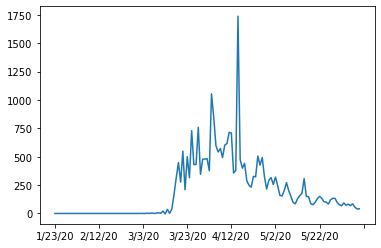

In [92]:
ny_cases = daily_new_cases_df.loc[daily_new_cases_df['County Name']=='New York County']
print(type(ny_cases))
ny_cases.iloc[0, 4:].plot()

In [ ]:
""" Load the data """
data = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv')
usa_map = gpd.read_file('misc/cb_2018_us_county_500k.shp')
county_populations = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv')
# county_data = pd.read_csv('misc/2019_Gaz_counties_national.txt', sep='\t')

""" Add in county population data """
data['population'] = county_populations.pop('population')

""" Drop a row in daily_new_cases_df if there isn't corresponding geolocation for that county in county_data """
for county_name in data['County Name'].unique():
    if county_name not in county_data['NAME'].unique():
#         print(county_name)
        data.drop(data[data['County Name']==county_name].index, inplace=True)
    
""" Drop NaNs just in case (there shouldn't be any) """
data.dropna(inplace=True)